# DiCE: Diverse Counterfactual Explanations for Hotel Cancellations

#### Attributions

The below code uses the [interpretml/DiCE](https://github.com/interpretml/DiCE) library (Copyright (c) Microsoft Corporation) in executing the below examples, as provided under the MIT License.

Modifications have been made where appropriate for conducting analysis on the tseries specific to this example.

The copyright and permission notices are made available below:

Copyright (c) Microsoft Corporation

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

The data used in this example is sourced from [Antonio, Almeida and Nunes (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191).

The below work and findings are not endorsed by the original authors in any way.

In [31]:
from platform import python_version

print(python_version())

3.6.9


H1short.csv simply refers to H1.csv. Please ignore the output for the below.

In [32]:
from google.colab import files
uploaded = files.upload()

Saving H1short.csv to H1short (1).csv


In [33]:
import pandas as pd
import io
dataset = pd.read_csv(io.BytesIO(uploaded['H1.csv']))

In [34]:
pip install tensorflow==1.15

In [35]:
# https://github.com/interpretml/DiCE
!pip install dice-ml

In [36]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [37]:
import dice_ml
from dice_ml.utils import helpers # helper functions

In [38]:
dataset

,IsCanceled,LeadTime,MarketSegment,DistributionChannel,CustomerType,RequiredCarParkingSpaces
0,0,342,Direct,Direct,Transient,0
1,0,737,Direct,Direct,Transient,0
2,0,7,Direct,Direct,Transient,0
3,0,13,Corporate,Corporate,Transient,0
4,0,14,Online TA,TA/TO,Transient,0
...,...,...,...,...,...,...
40055,0,212,Offline TA/TO,TA/TO,Transient,0
40056,0,169,Direct,Direct,Transient-Party,0
40057,0,204,Direct,Direct,Transient,0
40058,0,211,Offline TA/TO,TA/TO,Contract,0


In [39]:
# Dataset for training an ML model
d = dice_ml.Data(dataframe=dataset,
                 continuous_features=['LeadTime','RequiredCarParkingSpaces'],
                 outcome_name='IsCanceled')

In [40]:
type(d)

dice_ml.data_interfaces.public_data_interface.PublicData

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.optimizers import SGD

In [42]:
sess = tf.InteractiveSession()
# Generating train and test data
train, _ = d.split_data(d.normalize_data(d.one_hot_encoded_data))
X_train = train.loc[:, train.columns != 'IsCanceled']
y_train = train.loc[:, train.columns == 'IsCanceled']

# Fitting a dense neural network model
ann_model = Sequential()
ann_model.add(Dense(6, input_shape=(X_train.shape[1],), activation=tf.nn.relu))
ann_model.add(Dense(1, activation=tf.nn.sigmoid))
ann_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=ann_model.fit(X_train, y_train, validation_split=0.20, epochs=30, verbose=0, class_weight={0:1,1:2})
history

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


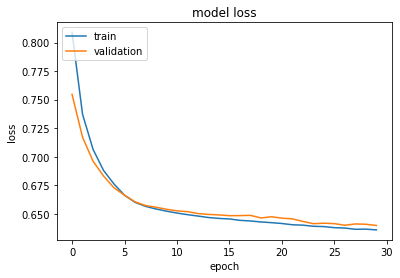

In [43]:
import matplotlib.pyplot as plt

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


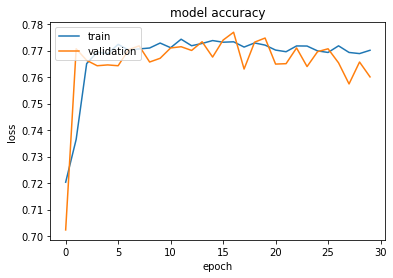

In [44]:
import matplotlib.pyplot as plt

print(history.history.keys())
# "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [45]:
X_train

,LeadTime,RequiredCarParkingSpaces,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_TA/TO,DistributionChannel_Undefined,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party
9677,0.024423,0.0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
2093,0.029851,0.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
15350,0.206242,0.0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
25832,0.244233,0.0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
19025,0.001357,0.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31044,0.001357,0.0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
25631,0.255088,0.0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
33174,0.127544,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
34959,0.207598,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,1


In [46]:
type(ann_model)

tensorflow.python.keras.engine.sequential.Sequential

In [47]:
# Generate the DiCE model for explanation
m = dice_ml.Model(model=ann_model)

In [48]:
m

In [49]:
new_d = dice_ml.Data(features={
                   'LeadTime':[0, 737],
                   'MarketSegment': ['Complementary', 'Corporate', 'Direct', 'Groups', 'Offline TA/TO', 'Online TA'],
                   'CustomerType': ['Contract', 'Group', 'Transient', 'Transient-Party'],
                   'DistributionChannel':['Corporate', 'Direct', 'TA/TO', 'Undefined'],
                   'RequiredCarParkingSpaces': [0, 8]},
         outcome_name='IsCanceled')

In [50]:
# DiCE explanation instance
exp = dice_ml.Dice(new_d,m)

In [51]:
exp

In [52]:
type(m)

dice_ml.model_interfaces.keras_tensorflow_model.KerasTensorFlowModel

In [53]:
query_instance = {'LeadTime': 68,
    'MarketSegment': 'Online TA',
    'CustomerType': 'Transient',
    'DistributionChannel': 'TA/TO',
    'RequiredCarParkingSpaces': 0}

In [54]:
# Generate counterfactual examples
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

Diverse Counterfactuals found! total time taken: 00 min 05 sec
Query instance (original outcome : 1)


,LeadTime,MarketSegment,CustomerType,DistributionChannel,RequiredCarParkingSpaces,IsCanceled
0,68.0,Online TA,Transient,TA/TO,0.0,0.666167


Diverse Counterfactual set without sparsity correction since only metadata about each feature is available (new outcome : 0)


,LeadTime,MarketSegment,CustomerType,DistributionChannel,RequiredCarParkingSpaces,IsCanceled
0,0.0,Online TA,Group,TA/TO,0.0,0.144
1,0.0,Online TA,Transient,Direct,7.0,0.000
2,70.0,Direct,Transient-Party,Corporate,2.0,0.000
3,737.0,Corporate,Transient,TA/TO,8.0,0.000


In [55]:
query_instance_2 = {'LeadTime': 93,
    'MarketSegment': 'Offline TA/TO',
    'CustomerType': 'Contract',
    'DistributionChannel': 'TA/TO',
    'RequiredCarParkingSpaces': 0}

In [56]:
# Generate counterfactual examples
dice_exp_2 = exp.generate_counterfactuals(query_instance_2, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp_2.visualize_as_dataframe()

Diverse Counterfactuals found! total time taken: 00 min 05 sec
Query instance (original outcome : 0)


,LeadTime,MarketSegment,CustomerType,DistributionChannel,RequiredCarParkingSpaces,IsCanceled
0,93.0,Offline TA/TO,Contract,TA/TO,0.0,0.458217


Diverse Counterfactual set without sparsity correction since only metadata about each feature is available (new outcome : 1)


,LeadTime,MarketSegment,CustomerType,DistributionChannel,RequiredCarParkingSpaces,IsCanceled
0,737.0,Complementary,Contract,TA/TO,0.0,0.844
1,191.0,Groups,Transient-Party,TA/TO,0.0,0.800
2,180.0,Offline TA/TO,Group,TA/TO,0.0,0.602
3,354.0,Groups,Transient,TA/TO,0.0,0.961


In [57]:
# Generate counterfactual examples
dice_exp_3 = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite", proximity_weight=1.5, diversity_weight=1.0)
# Visualize counterfactual explanation
dice_exp_3.visualize_as_dataframe()

Diverse Counterfactuals found! total time taken: 00 min 07 sec
Query instance (original outcome : 1)


,LeadTime,MarketSegment,CustomerType,DistributionChannel,RequiredCarParkingSpaces,IsCanceled
0,68.0,Online TA,Transient,TA/TO,0.0,0.666167


Diverse Counterfactual set without sparsity correction since only metadata about each feature is available (new outcome : 0)


,LeadTime,MarketSegment,CustomerType,DistributionChannel,RequiredCarParkingSpaces,IsCanceled
0,0.0,Online TA,Group,TA/TO,4.0,0.000
1,65.0,Online TA,Transient,Direct,0.0,0.175
2,64.0,Direct,Transient,TA/TO,1.0,0.000
3,737.0,Online TA,Transient,TA/TO,8.0,0.000


In [58]:
# Generate counterfactual examples
dice_exp_4 = exp.generate_counterfactuals(query_instance_2, total_CFs=4, desired_class="opposite", proximity_weight=1.5, diversity_weight=1.0)
# Visualize counterfactual explanation
dice_exp_4.visualize_as_dataframe()

Diverse Counterfactuals found! total time taken: 00 min 05 sec
Query instance (original outcome : 0)


,LeadTime,MarketSegment,CustomerType,DistributionChannel,RequiredCarParkingSpaces,IsCanceled
0,93.0,Offline TA/TO,Contract,TA/TO,0.0,0.458217


Diverse Counterfactual set without sparsity correction since only metadata about each feature is available (new outcome : 1)


,LeadTime,MarketSegment,CustomerType,DistributionChannel,RequiredCarParkingSpaces,IsCanceled
0,737.0,Offline TA/TO,Contract,TA/TO,0.0,0.792
1,99.0,Complementary,Contract,TA/TO,0.0,0.809
2,134.0,Offline TA/TO,Group,TA/TO,0.0,0.543
3,152.0,Groups,Contract,TA/TO,0.0,0.954


In [59]:
# Generate counterfactual examples
dice_exp_5 = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite", proximity_weight=1.0, diversity_weight=2.5)
# Visualize counterfactual explanation
dice_exp_5.visualize_as_dataframe()

Diverse Counterfactuals found! total time taken: 00 min 04 sec
Query instance (original outcome : 1)


,LeadTime,MarketSegment,CustomerType,DistributionChannel,RequiredCarParkingSpaces,IsCanceled
0,68.0,Online TA,Transient,TA/TO,0.0,0.666167


Diverse Counterfactual set without sparsity correction since only metadata about each feature is available (new outcome : 0)


,LeadTime,MarketSegment,CustomerType,DistributionChannel,RequiredCarParkingSpaces,IsCanceled
0,0.0,Online TA,Group,Corporate,5.0,0.000
1,0.0,Online TA,Transient,TA/TO,7.0,0.000
2,347.0,Direct,Transient-Party,TA/TO,0.0,0.259
3,737.0,Corporate,Transient,Direct,8.0,0.000


In [60]:
# Generate counterfactual examples
dice_exp_6 = exp.generate_counterfactuals(query_instance_2, total_CFs=4, desired_class="opposite", proximity_weight=1.0, diversity_weight=2.5)
# Visualize counterfactual explanation
dice_exp_6.visualize_as_dataframe()

Diverse Counterfactuals found! total time taken: 00 min 05 sec
Query instance (original outcome : 0)


,LeadTime,MarketSegment,CustomerType,DistributionChannel,RequiredCarParkingSpaces,IsCanceled
0,93.0,Offline TA/TO,Contract,TA/TO,0.0,0.458217


Diverse Counterfactual set without sparsity correction since only metadata about each feature is available (new outcome : 1)


,LeadTime,MarketSegment,CustomerType,DistributionChannel,RequiredCarParkingSpaces,IsCanceled
0,737.0,Direct,Transient,TA/TO,0.0,0.800
1,76.0,Groups,Contract,Undefined,0.0,0.543
2,108.0,Offline TA/TO,Group,TA/TO,0.0,0.516
3,737.0,Complementary,Contract,Direct,0.0,0.646
